In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
import series as s
from download import query_phe as query, download_phe as download, find_latest
from phe import plot_summary, read_csv, load_population, current_and_previous_data
from plotting import per1m_formatter, per1k_formatter, per0k_formatter
from vaccination import vaccination_dashboard, vaccination_changes
import requests

In [17]:
release=None

In [18]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-02-08,2021-02-07,United Kingdom,K02000001,2922,NaN,96.0,584933.0
1,2021-02-08,2021-02-06,United Kingdom,K02000001,10005,NaN,252.0,454008.0
2,2021-02-08,2021-02-05,United Kingdom,K02000001,15140,NaN,423.0,671585.0
3,2021-02-08,2021-02-04,United Kingdom,K02000001,17541,2107.0,571.0,783851.0
4,2021-02-08,2021-02-03,United Kingdom,K02000001,19279,2334.0,725.0,801949.0
...,...,...,...,...,...,...,...,...
370,2021-02-08,2020-02-03,United Kingdom,K02000001,0,NaN,NaN,NaN
371,2021-02-08,2020-02-02,United Kingdom,K02000001,1,NaN,NaN,NaN
372,2021-02-08,2020-02-01,United Kingdom,K02000001,1,NaN,NaN,NaN
373,2021-02-08,2020-01-31,United Kingdom,K02000001,2,NaN,NaN,NaN


In [19]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-02-08.csv')

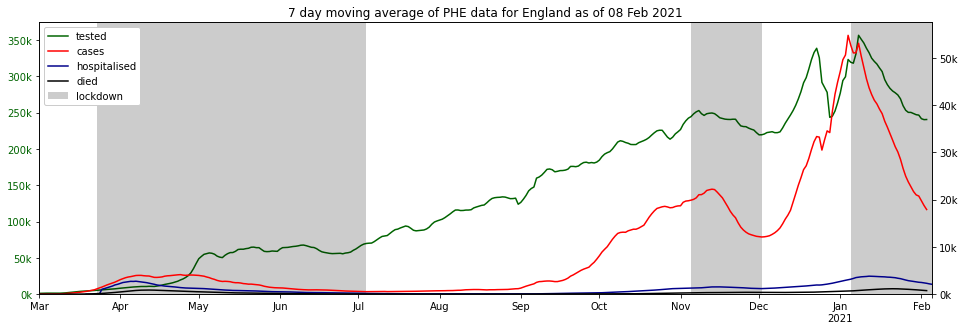

In [20]:
plot_summary(earliest_date='2020-03-01')

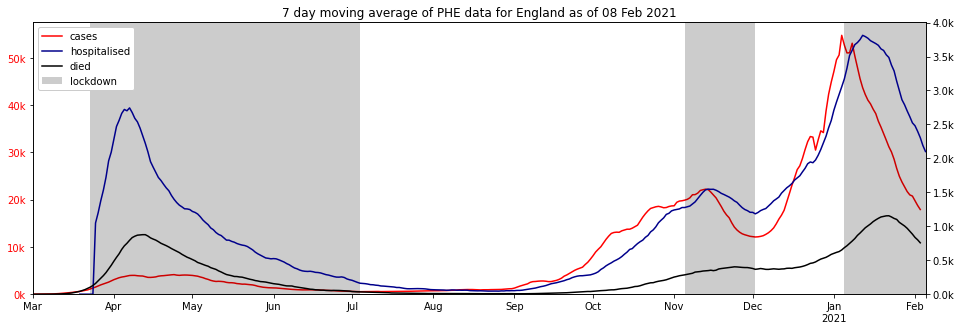

In [21]:
plot_summary(earliest_date='2020-03-01', left_series=(s.new_cases_sum,), 
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

In [22]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-02-08.csv')

In [23]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-02-08.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,471636.0,10519729.0,10048093.0,56286961,0.837913,17.851546,81.310540
1,Northern Ireland,N92000002,27463.0,303478.0,276015.0,1893667,1.450255,14.575688,83.974057
2,Scotland,S92000003,10818.0,866823.0,856005.0,5463300,0.198012,15.668277,84.133710
3,Wales,W92000004,2792.0,603976.0,601184.0,3152879,0.088554,19.067779,80.843667


'partial: 12,294,006'

'full: 512,709'

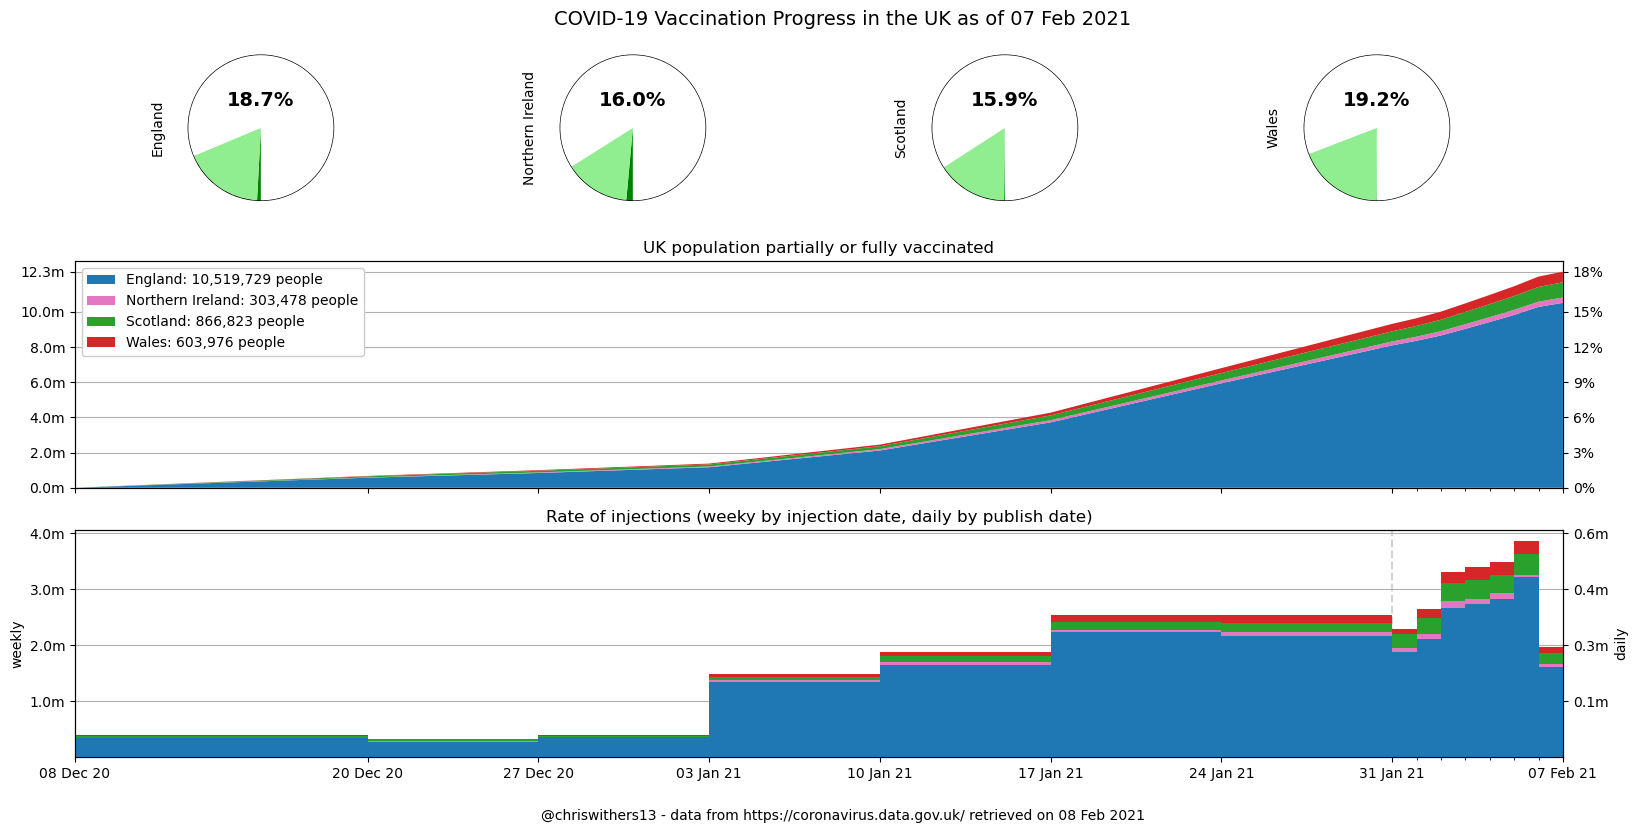

In [24]:
results = vaccination_dashboard()
display(results, f"partial: {results['any'].sum():,.0f}", f"full: {results['full'].sum():,.0f}")

In [25]:
vaccination_changes()

In [26]:
download(nation, nation, new_admissions, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-02-08.csv')

In [27]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-02-08.csv')

In [28]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-02-08.csv')